In [ ]:
# prompt: please install all the below using pip

#!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow keras clean_text pandarallel


In [1]:
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim
import logging
from gensim.models.doc2vec import TaggedDocument

import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.lm import Vocabulary
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, Normalizer
import joblib
from cleantext import clean
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from pandarallel import pandarallel
import ast
import math
from imblearn.under_sampling import RandomUnderSampler
pandarallel.initialize(progress_bar=True)
import time
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

import os
IN_COLAB = False
if os.getenv("COLAB_RELEASE_TAG"):
   IN_COLAB = True

news_processed = None
bbc_proccessed = None
dataPath = "../data/"

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


[nltk_data] Downloading package punkt to /Users/suneg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/suneg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/suneg/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

# Part 1 (Data Processing)

### Task 1
Retrive data sample

In [ ]:
# Data path
if IN_COLAB:
  dataPath = "/content/drive/MyDrive/"

# Read data from csv using pandas
nsdf = pd.read_csv(dataPath + "news_sample.csv")
nsdf = nsdf.reset_index(drop=True)  # Reset index??

# Safe raw data
nsdf_raw = nsdf.copy(deep=True)

nsdf.info()   # Check column types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        250 non-null    int64  
 1   id                250 non-null    int64  
 2   domain            250 non-null    object 
 3   type              238 non-null    object 
 4   url               250 non-null    object 
 5   content           250 non-null    object 
 6   scraped_at        250 non-null    object 
 7   inserted_at       250 non-null    object 
 8   updated_at        250 non-null    object 
 9   title             250 non-null    object 
 10  authors           170 non-null    object 
 11  keywords          0 non-null      float64
 12  meta_keywords     250 non-null    object 
 13  meta_description  54 non-null     object 
 14  tags              27 non-null     object 
 15  summary           0 non-null      float64
dtypes: float64(2), int64(2), object(12)
memory u

In [ ]:
# unique lable values
unique_values = nsdf['type'].unique()
print(unique_values)

['unreliable' 'fake' 'clickbait' 'conspiracy' 'reliable' 'bias' 'hate'
 'junksci' 'political' nan 'unknown']


In [ ]:
#nan and unknown removed as they seem useless when training a classifier
nsdf = nsdf.dropna(subset=['type'])
nsdf = nsdf.loc[nsdf['type']!='unknown']
newunique_values = nsdf['type'].unique()
print(newunique_values)


['unreliable' 'fake' 'clickbait' 'conspiracy' 'reliable' 'bias' 'hate'
 'junksci' 'political']


#### Cleaning and Preprocessing functions

To test the different functions and see the reduction in vocabularity size

In [ ]:
def cleanText(data, column):
    data[column] = data[column].parallel_apply(clean_text_help)
    return data

def clean_text_help(text):
    if isinstance(text, str):
        # Remove excess whitespace
        text = re.sub(r"\s+", " ", text).strip()
        #replace dates
        text = re.sub(r"(0[1-9]|[1-2][0-9]|3[0-1])[-/.]?(0[1-9]|1[0-2])[-/.]?([0-9]{2}|[0-9]{4})", "<DATE>", text)  # Replace date type 1
        text = re.sub(r"(0[1-9]|[1-2][0-9]|3[0-1])\s([A-Za-z]{3})\s([0-9]{2}|[0-9]{4})", "<DATE>", text)  # Replace date type 2
        return clean(text, lower=True, no_line_breaks=True, no_numbers=True, no_emails=True, no_urls=True, no_punct=True, replace_with_url=r"__URL__", replace_with_email=r"__EMAIL__", replace_with_number=r"__NUM__", replace_with_digit=r"__NUM__")
    raise TypeError("Clean_text passed non-string")

In [ ]:
#Tokenize the text function
def tokenizeText(data, column):
    def tokenize_text_help(text):
        if isinstance(text, str):
            return (word_tokenize(text))
        return text  # Return unchanged if not a string
    data[column] = data[column].parallel_apply(tokenize_text_help)  # Apply function
    return data

In [ ]:
#function for removeing stopwords
def remove_stopwords_help(text):
    text = pd.Series(text)
    stop_words = set(stopwords.words('english'))  # Load stopwords
    return text[~text.isin(stop_words)].to_list()  # Remove stopwords

def remove_stopwords(data, column):
    data['content'] = data['content'].parallel_apply(remove_stopwords_help)  # Apply function
    return data

In [ ]:
#Returns a pandas series, with word and frequency, very fast.
def getFreq(data, column):
    return len(data[column].str.split().explode().value_counts())

def getFreq_tokinized(data, column):
    return len(data[column].explode().value_counts())

def Vocab_size_tokinized(data, column):
    return len(data[column].explode())

def Vocab_size(data, column):
    return len(data[column].str.split().explode())

In [ ]:

#function for removeing stopwords
def dataStemming(data, column):
    ps = PorterStemmer()
    def dataStemming_help(text):
        text = pd.Series(text)
        if(isinstance(text, str)):
            return pd.Series(ps.stem(text))
        return text.apply(ps.stem).to_list()
    data[column] = data[column].parallel_apply(dataStemming_help)  # Apply function
    return data


#### Looking at unique and overall word reduction

In [ ]:
def calc_reduction(start_value, end_value):
    return round(((start_value - end_value)/start_value)*100, 2)


printing_copy = nsdf_raw.copy(deep=True)
freq_raw = getFreq(printing_copy, 'content')
data_size_raw = Vocab_size(printing_copy, 'content')

printing_copy = printing_copy.dropna(subset=['type'])
printing_copy = printing_copy.loc[printing_copy['type']!='unknown']

freq_pre = getFreq(printing_copy, 'content')
data_size_pre = Vocab_size(printing_copy, 'content')
freq_clean = getFreq(cleanText(printing_copy, 'content'), 'content')
data_size_clean = Vocab_size(printing_copy, 'content')
freq_token = getFreq_tokinized(tokenizeText(printing_copy, 'content'), 'content')
data_size_token = Vocab_size_tokinized(printing_copy, 'content')
freq_stopwords = getFreq_tokinized(remove_stopwords(printing_copy, 'content'), 'content')
data_size_stopwords = Vocab_size_tokinized(printing_copy, 'content')
freq_stemmed = getFreq_tokinized(dataStemming(printing_copy, 'content'), 'content')
data_size_stemmed = Vocab_size_tokinized(printing_copy, 'content')


print("--- Unique words ---")
print("Raw: ", freq_raw)
print("Preprocessing: ", freq_pre, "reduction: ", calc_reduction(freq_raw, freq_pre))
print("After cleaning: ", freq_clean, "reduction: ", calc_reduction(freq_raw, freq_clean))
print("After tokenizing: ", freq_token, "reduction: ", calc_reduction(freq_raw, freq_token))
print("After removing stopwords: ", freq_stopwords, "reduction: ", calc_reduction(freq_raw, freq_stopwords))
print("After stemming: ", freq_stemmed, "reduction: ", calc_reduction(freq_raw, freq_stemmed))

print(" ")

print("--- Word counts ---")
print("Raw: ", data_size_raw)
print("Preprosseing: ", data_size_pre, "reduction: ", calc_reduction(data_size_raw, data_size_pre))
print("After cleaning: ", data_size_clean, "reduction: ", calc_reduction(data_size_raw, data_size_clean))
print("After tokenizing: ", data_size_token, "reduction: ", calc_reduction(data_size_raw, data_size_token))
print("After removing stopwords: ", data_size_stopwords, "reduction: ", calc_reduction(data_size_raw, data_size_stopwords))
print("After stemming: ", data_size_stemmed, "reduction: ", calc_reduction(data_size_raw, data_size_stemmed))


#Delete copy:
del printing_copy
del freq_pre, data_size_pre, freq_clean, data_size_clean, freq_token, data_size_token, freq_stopwords, data_size_stopwords, freq_stemmed, data_size_stemmed



#### Processing and cleaning function

In [ ]:
# One big function to process data:
def processData(data, column, stemming=True):
    def apply_sequential_helper(functions):
        # assume type siganture of functions to be List[f : String -> string ]
        def inner(text):
            for f in functions:
                text = f(text)
            return text
        return inner

    def clean_text_help(text):
        if isinstance(text, str):
            # Remove excess whitespace
            text = re.sub(r"\s+", " ", text).strip()
            # remove non-ascii
            text = re.sub(r'[^\w _]+', '', text)
            
            #replace dates
            text = re.sub(r"(0[1-9]|[1-2][0-9]|3[0-1])[-/.]?(0[1-9]|1[0-2])[-/.]?([0-9]{2}|[0-9]{4})", " __DATE__ ", text)  # Replace date type 1
            text = re.sub(r"(0[1-9]|[1-2][0-9]|3[0-1])\s([A-Za-z]{3})\s([0-9]{2}|[0-9]{4})", " __DATE__ ", text)  # Replace date type 2

            return clean(text, lower=True, no_line_breaks=True, no_currency_symbols=True, no_numbers=True, 
                         no_emails=True, no_urls=True, no_punct=True, replace_with_url=r" __URL__ ", replace_with_email=r" __EMAIL__ ", 
                         replace_with_number=r" __NUM__ ", replace_with_digit=r" __NUM__ ", replace_with_currency_symbol=r" __CUR__ ")
        raise TypeError("Clean_text passed non-string")

    def tokenize_text_help(text):
        if isinstance(text, str):
            return pd.Series(word_tokenize(text))
        return text  # Return unchanged if not a string

    def remove_stopwords_help(text):
      # text is a Series[str]
        stop_words = set(stopwords.words('english'))  # Load stopwords
        #if isinstance(text, str):
        #    return [word for word in text.at[0, 'content'] if not word.lower() in stop_words]
        #return text  # Return unchanged if not a string
        return text[~text.isin(stop_words)]

    ps = PorterStemmer()
    def dataStemming_help(text):
        #if isinstance(text, str):
        #    return ps.stem(text)
        #return text  # Return unchanged if not a string
        if(isinstance(text, str)):
            return pd.Series(ps.stem(text))
        return text.apply(ps.stem)

    def type_cleaner(text):
        if isinstance(text, str):
            return pd.Series(text).to_list()
        return text.to_list()

    data[column] = data[column].parallel_apply(apply_sequential_helper(
        [clean_text_help, # str -> str
        tokenize_text_help, # str -> list[str]
        remove_stopwords_help, #series[str] -> series[str]
        dataStemming_help if stemming else lambda x:x, #series[str] -> series[str]
        type_cleaner # series[str] -> series[str]
    ]))
    return data

In [ ]:

nsdf_processed = processData(nsdf, 'content')
nsdf_processed.dropna(subset=['content'], inplace=True)  # Drop rows with no content
nsdf_processed.reset_index(drop=True, inplace=True)  # Reset index
print(nsdf_processed.at[0, 'content'])

TypeError: Clean_text passed non-string

### Task 2

In [ ]:
#load data
fakeNewsCorpus = pd.read_csv(dataPath + "995,000_rows.csv")
#Hva saten er den der unnamed???
print(fakeNewsCorpus.head())
print(fakeNewsCorpus['content'].shape)
news_noDup = fakeNewsCorpus.drop_duplicates(subset=['content']).dropna(subset=['content']).reset_index(drop=True)
news_noDup = news_noDup.loc[(news_noDup['type']!='unknown') & (news_noDup['type']!='unreliable') & (news_noDup['type'] != '2018-02-10 13:43:39.521661')]

/var/folders/95/npq_3klx42xc1jgcjnly4y4m0000gn/T/ipykernel_53935/795245403.py:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  fakeNewsCorpus = pd.read_csv(dataPath + "995,000_rows.csv")


  Unnamed: 0         id               domain        type  \
0        732  7444726.0   nationalreview.com   political   
1       1348  6213642.0    beforeitsnews.com        fake   
2       7119  3867639.0     dailycurrant.com      satire   
3       1518  9560791.0          nytimes.com    reliable   
4       9345  2059625.0  infiniteunknown.net  conspiracy   

                                                 url  \
0  http://www.nationalreview.com/node/152734/%E2%...   
1  http://beforeitsnews.com/economy/2012/06/the-c...   
2  http://dailycurrant.com/2016/01/18/man-awoken-...   
3  https://query.nytimes.com/gst/fullpage.html?re...   
4  http://www.infiniteunknown.net/2011/09/14/100-...   

                                             content  \
0  Plus one article on Google Plus\n\n(Thanks to ...   
1  The Cost Of The Best Senate Banking Committee ...   
2  Man Awoken From 27-Year Coma Commits Suicide A...   
3  WHEN Julia Geist was asked to draw a picture o...   
4  – 100 Compiled Stud

In [ ]:
print(news_noDup.shape[0])

766045


In [ ]:
#Cleaning
news_processed = processData(news_noDup, 'content')
news_processed.to_json(dataPath + "news_processed.json", orient='records', lines=True)

### Task 3

In [3]:
if news_processed is None:
    json_reader = pd.read_json(dataPath + "news_processed.json", orient='records', lines=True, chunksize=1500)
    news_processed = pd.concat(json_reader, ignore_index=True)
# timed: 12 min på M1 macbook chunk=1000
print(news_processed.info())   # Check column types and missing values
#fndf = fakeNewsCorpus.reset_index(drop=True)  # Reset index


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766045 entries, 0 to 766044
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        766045 non-null  int64         
 1   id                766045 non-null  int64         
 2   domain            766045 non-null  object        
 3   type              723732 non-null  object        
 4   url               766045 non-null  object        
 5   content           766045 non-null  object        
 6   scraped_at        766045 non-null  object        
 7   inserted_at       766045 non-null  datetime64[ns]
 8   updated_at        766045 non-null  datetime64[ns]
 9   title             765887 non-null  object        
 10  authors           475077 non-null  object        
 11  keywords          0 non-null       float64       
 12  meta_keywords     728137 non-null  object        
 13  meta_description  400832 non-null  object        
 14  tags

## Observations about dataset

In [4]:
fndf = news_processed
unique_values = fndf['type'].unique()
print(unique_values)
#hard to know how to classify nan and unknown, so removed for now
# we also remove the a weird type 
fndf = fndf.dropna(subset=['type'])
fndf = fndf.loc[(fndf['type']!='unknown') & (fndf['type']!='unreliable') & (fndf['type'] != '2018-02-10 13:43:39.521661')]# & (fndf['type'] != "rumor")]
# Need to reset index

newunique_values = fndf['type'].unique()
print(newunique_values)


['political' 'fake' 'satire' 'reliable' 'conspiracy' 'bias' 'rumor' None
 'clickbait' 'hate' 'junksci']
['political' 'fake' 'satire' 'reliable' 'conspiracy' 'bias' 'rumor'
 'clickbait' 'hate' 'junksci']


In [ ]:
print(fndf["type"].value_counts())

type
reliable      211836
political     141083
bias           97589
fake           92879
conspiracy     71442
rumor          52604
clickbait      25844
junksci        11434
satire         10695
hate            8326
Name: count, dtype: int64


In [ ]:
# requires running all_dist loading out fo order, since we need word distributions

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

#vocab = fndf["content"].explode().value_counts().index[:10000]

#vocab = {val for (val, _) in all_dist.most_common(10000)}
tfidf_all_model = TfidfVectorizer(analyzer=lambda x: x, max_features=10000)
tfidf_vec = tfidf_all_model.fit_transform(fndf["content"])


In [31]:
print(fndf["content"][100])

['strongest', 'form', 'continu', 'bia', 'america', 'bigotri', 'partisan', 'ideolog', 'america', 'today', 'gener', 'frown', 'bigot', 'well', 'almost', 'harbor', 'neg', 'racial', 'animu', 'even', 'undu', 'positivesupremacist', 'racial', 'view', 'quit', 'peopl', 'call', 'openli', 'critic', 'valid', 'think', 'num', 'rec', 'polit', 'belief', 'creat', 'religi', 'war', 'like', 'religion', 'religion', 'new', 'rule', 'struggl', 'year', 'figur', 'deep', 'polit', 'belief', 'run', 'right', 'wing', 'abil', 'ignorantli', 'refus', 'understand', 'accept', 'truth', 'fact', 'confus', 'ive', 'tri', 'figur', 'realli', 'know', 'num', 'rec', 'alsen', 'forcedbirth', 'support', 'suspect', 'pervert', 'senat', 'abort', 'given', 'vehem', 'roy', 'moor', 'yell', 'fake', 'news', 'respons', 'alleg', 'sexual', 'assault', 'women', 'girl', 'pursu', 'girl', 'young', 'enough', 'daughter', 'natur', 'wonder', 'would', 'respond', 'advanc', 'num', 'rec', 'antigay', 'politician', 'serv', 'minimum', 'num', 'year', 'sex', 'traf

In [47]:
from sklearn.decomposition import TruncatedSVD

tfidf_vec_scale = tfidf_vec
PCA_model = PCA(n_components=2)
#PCA_data = PCA_model.fit_transform(tfidf_vec_scale)
PCA_real = PCA_model.fit_transform(tfidf_vec_scale[fndf["type"]==0])
PCA_fake = PCA_model.fit_transform(tfidf_vec_scale[fndf["type"]==1])
#PCA_df = pd.DataFrame([PCA_real, PCA_fake], columns=["PCA1", "PCA2"])
PCA_df = pd.concat([pd.DataFrame(PCA_real, columns=["PCA1", "PCA2"]), pd.DataFrame(PCA_fake, columns=["PCA1", "PCA2"])])
PCA_df["type"] = fndf["type"]

#sns.kdeplot(x=PCA_real[:, 0], y=PCA_real[:, 1],color="blue", thresh=0.15)
#sns.kdeplot(x=PCA_fake[:, 0], y=PCA_fake[:, 1],color="red", thresh=0.15, alpha=0.7)

KeyboardInterrupt: 

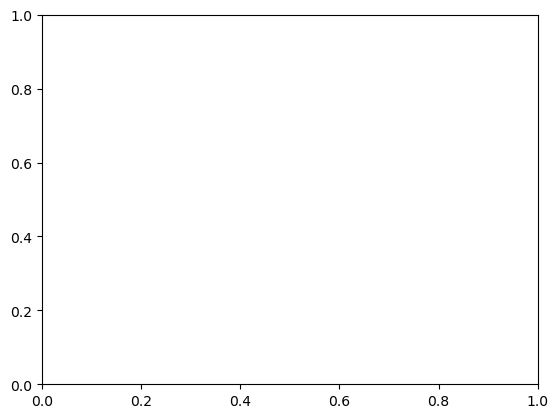

In [46]:
sns.kdeplot(data=PCA_df, x="PCA1", y="PCA2", hue="type", fill=False, alpha=0.5)

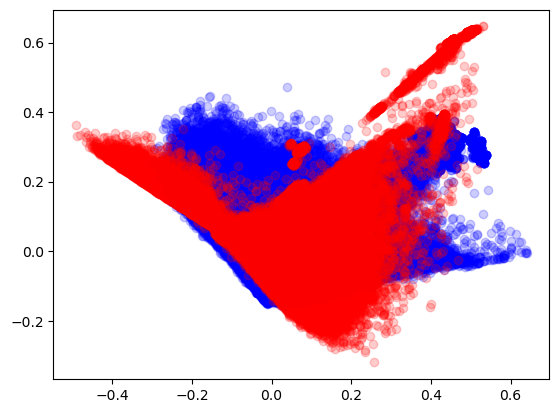

In [49]:
#sns.scatterplot(data=PCA_df, x="PCA2", y="PCA1", hue="type", alpha=1)
plt.scatter(PCA_real[:, 0], PCA_real[:, 1], color="blue", label="Real", alpha=0.2)
plt.scatter(PCA_fake[:, 0], PCA_fake[:, 1], color="red", label="Fake", alpha=0.2)

In [5]:

# groups (reliable) as truenews 1 and (all others) in fakenews 0
    #note this is naive and should be reconsidered later

# reliable, clickbait and political are all, by their contents, factually correct (albeit possibly politcally motivated)
# we deem those to be "real" news
print("adding binary labels")
fndf['type'] = fndf['type'].replace(r'^(reliable|clickbait|political)$', '0', regex=True) 
fndf['type'] = fndf['type'].replace(r'^(?!0$).+', '1', regex=True)   # Replace everything except '1' with '0'
#maybe fix this? what remains?
fndf['type'] = fndf['type'].fillna('0')

newunique_values = fndf['type'].unique()
print(newunique_values)
fndf.shape[0]
fndf['type'] = fndf['type'].astype(int)  # Convert to integer

print(("real vs fake:"))
print(fndf['type'].value_counts())

adding binary labels
['0' '1']
real vs fake:
type
0    378763
1    344969
Name: count, dtype: int64


In [ ]:

print(relib_news.shape[0], " : ", fake_news.shape[0])

print("distribution for real news")
#print(relib_news["content"].explode().value_counts())
real_dist = FreqDist(relib_news["content"].explode())
print(real_dist.most_common(200))

print("distribution for fake news")
#print(fake_news["content"].explode().value_counts())
fake_dist = FreqDist(fake_news["content"].explode())
print(fake_dist.most_common(200))

print("distribution for all news")
#print(fndf["content"].explode().value_counts())
all_dist = FreqDist(fndf["content"].explode())
print(all_dist.most_common(200))
joblib.dump((real_dist, fake_dist, all_dist), dataPath + "dists.pkl")

In [ ]:

(real_dist, fake_dist, all_dist) = joblib.load(dataPath + "dists.pkl")

        Unnamed: 0       id              domain  type  \
0            732.0  7444726  nationalreview.com     1   
3           1518.0  9560791         nytimes.com     1   
5           3732.0  8018634      online.wsj.com     1   
6           7968.0  3527674        dailykos.com     1   
7           2968.0  2015968        dailykos.com     1   
...            ...      ...                 ...   ...   
812899      7978.0  9377040         nytimes.com     1   
812901      4912.0  3244085        dailykos.com     1   
812904      2427.0  8481486         nytimes.com     1   
812906      7584.0  8546643         nytimes.com     1   
812907      7167.0  9326229         nytimes.com     1   

                                                      url  \
0       http://www.nationalreview.com/node/152734/%E2%...   
3       https://query.nytimes.com/gst/fullpage.html?re...   
5       http://online.wsj.com/articles/shift-options-1...   
6       https://www.dailykos.com/stories/2014/05/02/12...   
7       ht

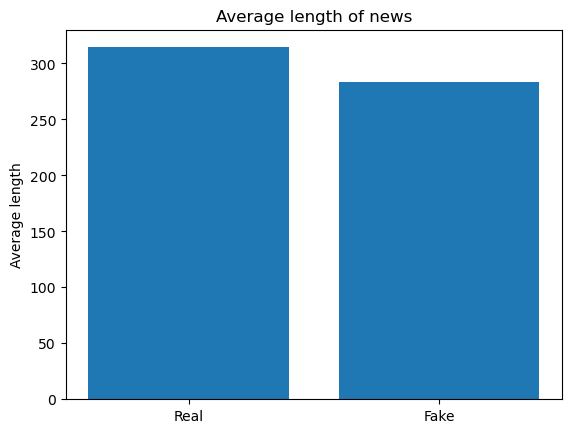

In [ ]:
avg_len_real = relib_news["content"].apply(len).mean()
print(relib_news)
avg_len_fake = fake_news["content"].apply(len).mean()
print("Average length of real news: ", avg_len_real)
print("Average length of fake news: ", avg_len_fake)
plt.bar(["Real", "Fake"], [avg_len_real, avg_len_fake])
plt.title("Average length of news")
plt.ylabel("Average length")
plt.show()

In [ ]:
# add one discounting
fake_total = int(pd.Series([b+1 for (a, b) in fake_dist.most_common(10000)]).sum())
real_total = int(pd.Series([b+1 for (a, b) in real_dist.most_common(10000)]).sum())
all_total = int(pd.Series([b+1 for (a, b) in all_dist.most_common(10000)]).sum())
print(f"real total: {real_total}, fake total: {fake_total}")
print(real_total-fake_total)


real total: 109315624, fake total: 85853406
23462218


In [ ]:

real_pd_prob = pd.Series(dict(real_dist)).apply(lambda x: x/real_total)
fake_pd_prob = pd.Series(dict(fake_dist)).apply(lambda x: x/fake_total)



In [ ]:
def entropy_calculation(row):
    word = row["word"]
    # use one cause of add one discounting
    row["real_prob"] = real_dist.get(word, 1) / all_dist.get(word, 1/all_total)
    #row["real_prob"] = real_prob
    row["fake_prob"] = fake_dist.get(word, 1) / all_dist.get(word, 1/all_total)
    #row["fake_prob"] = fake_prob
    #row["fake_prob"] = -1*fake_prob*np.log2(fake_prob)
    #row["real_entropy"] = -1*real_prob*np.log2(real_prob)
    #row["entropy"] = row["fake_entropy"] + row["real_entropy"]
    row["prob_diff"] = abs(row["real_prob"] - row["fake_prob"])
    return row
    

In [ ]:
word_entropy = pd.DataFrame(all_dist.most_common(1000), columns=["word", "count"]).apply(entropy_calculation, axis=1)
word_entropy = word_entropy.sort_values("fake_prob", ascending=False)
print(word_entropy.head(20))

          word   count  real_prob  fake_prob  prob_diff
889      getti   51272   0.065026   0.934974   0.869949
720       cent   62940   0.171830   0.828170   0.656339
755       gold   60003   0.230005   0.769995   0.539990
878         uk   51675   0.236110   0.763890   0.527779
190      sourc  158033   0.256035   0.743965   0.487930
943     syrian   48433   0.257634   0.742366   0.484731
683     reader   65597   0.261917   0.738083   0.476165
290     russia  125465   0.273295   0.726705   0.453409
809      earth   55830   0.276518   0.723482   0.446964
916         un   49879   0.276690   0.723310   0.446621
299         de  121753   0.276700   0.723300   0.446601
572      syria   75366   0.277751   0.722249   0.444498
103        url  209053   0.284363   0.715637   0.431273
349    russian  108299   0.293761   0.706239   0.412478
477         la   85678   0.294638   0.705362   0.410724
523        add   79471   0.316442   0.683558   0.367115
517          |   79919   0.331285   0.668715   0

<Axes: xlabel='word'>

<Figure size 1400x900 with 0 Axes>

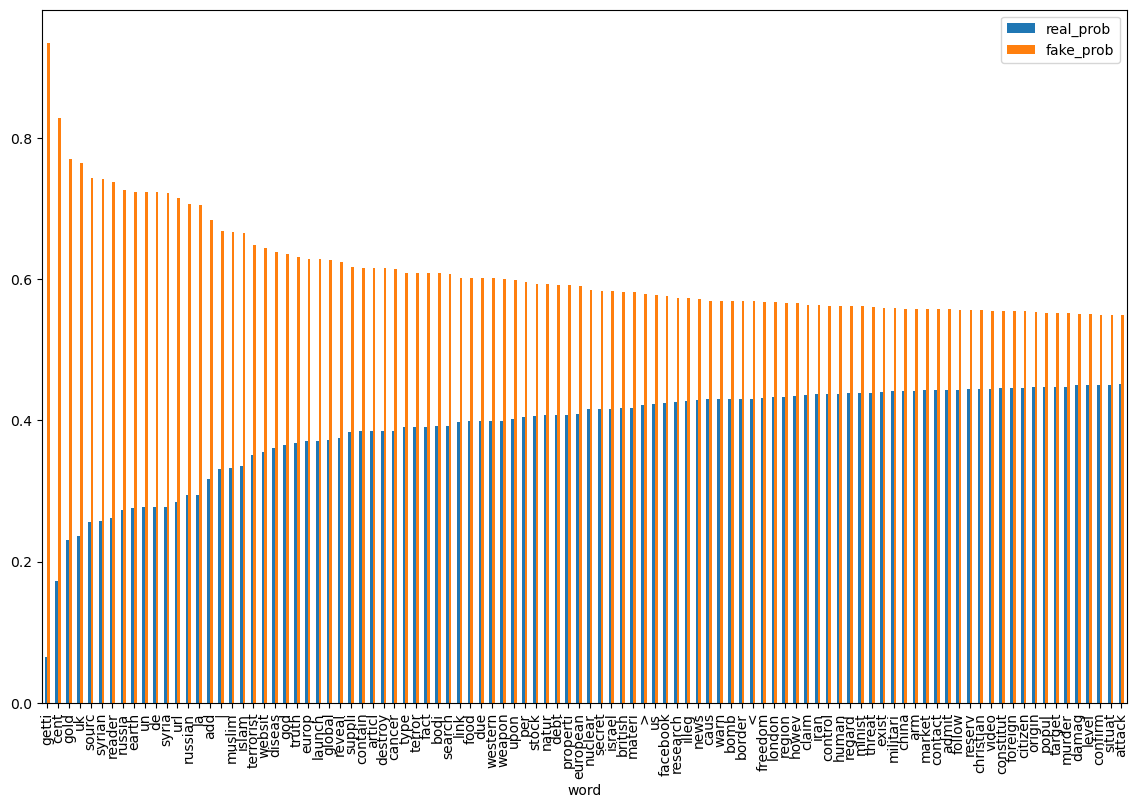

In [ ]:
plt.figure(figsize=(14, 9))

word_entropy_lim = word_entropy.head(100)
width = 0.2
# Bar chart with stacking
#plt.bar(word_entropy_lim["word"], word_entropy_lim["real_prob"] + word_entropy_lim["fake_prob"], label="Real", color="blue")
#plt.bar(word_entropy_lim["word"], word_entropy_lim["fake_prob"], label="Fake", color="red")
"""
plt.bar(word_entropy_lim["word"])

# Labels and title
plt.xlabel("Words")
plt.ylabel("Entropy")
plt.title("Stacked Bar Chart of Real vs. Fake Entropy per Word")
plt.legend()

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Show plot
plt.show()
"""

word_entropy_lim[["word", "real_prob", "fake_prob"]].plot(kind='bar', x='word', stacked=False, figsize=(14, 9))

In [ ]:
# tf idf
from sklearn.feature_extraction.text import TfidfVectorizer

vocab = {val for (val, _) in all_dist.most_common(10000)}
print(vocab)
tfidf_real_vec = TfidfVectorizer(analyzer=lambda x: x, vocabulary=vocab)
tfidf_fake_vec = TfidfVectorizer(analyzer=lambda x: x, vocabulary=vocab)
tfidf_real = tfidf_real_vec.fit_transform(relib_news["content"])
tfidf_fake = tfidf_fake_vec.fit_transform(fake_news["content"])



{'jenni', 'mock', 'blockbust', 'convoy', 'distrust', 'disallow', 'slate', 'grown', 'pablo', 'myer', 'outlet', 'momentum', 'alumni', 'epidem', 'honesti', 'hid', 'novak', 'relentlessli', 'layer', 'triangl', 'backyard', 'iron', 'weiner', 'salut', 'frontpag', 'ton', 'persist', 'superfici', 'quarterfin', 'domino', 'frack', 'theatric', 'taxexempt', 'casey', 'acut', 'break', 'mojo', 'thu', '29th', 'warrior', 'freshman', 'philadelphia', 'howev', 'ml', 'insur', 'granddaught', 'bonu', 'sneak', 'current', 'collid', 'mugab', 'cheat', 'williamsburg', 'lesser', 'medit', 'selfproclaim', 'resign', 'reagan', 'colbert', 'dub', 'tourism', 'stigma', 'coalit', 'prolong', 'amnesti', 'powerless', 'thread', 'kentucki', 'cant', 'filthi', 'adapt', 'grace', 'sink', 'dissolv', 'menu', 'brandon', 'documentari', 'polish', 'raymond', 'boss', 'discriminatori', 'specialist', 'dreamer', 'nova', 'disgrac', 'starvat', 'luck', 'debbi', 'unconsci', 'exit', 'heavenli', 'antiwar', 'real', 'psychic', '30', 'lesson', 'compromi

PicklingError: Can't pickle <function <lambda> at 0x690f6f740>: it's not found as __main__.<lambda>

In [ ]:
tfidf_all_real = Normalizer().fit_transform(tfidf_all_model.transform(fndf.loc[fndf["type"] == 0, "content"]))
tfidf_all_fake = Normalizer().fit_transform(tfidf_all_model.transform(fndf.loc[fndf["type"] == 1, "content"]))

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107507fe0>>
Traceback (most recent call last):
  File "/Users/suneg/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [8]:
from sklearn.decomposition import PCA
tfidf_model = TfidfVectorizer(analyzer=lambda x: x, max_features=10000)
tfidf_vec = tfidf_model.fit_transform(fndf["content"])
tfidf_vec_scale = StandardScaler(with_mean=False).fit_transform(tfidf_vec)
PCA_model = PCA(n_components=2)
PCA_data = PCA_model.fit_transform(tfidf_vec_scale)
#PCA_data["type"] = fndf["type"]

In [10]:
print(PCA_data)

[[-0.38087416 -1.90565117]
 [ 0.4535421  -3.56158718]
 [ 0.88597027 -3.74514316]
 ...
 [-1.08642789  1.66748301]
 [ 2.26436531 -8.36004067]
 [ 1.0378497  -4.61022031]]


In [ ]:

joblib.dump((tfidf_real, tfidf_fake, tfidf_all_real, tfidf_all_fake), dataPath + "tfidf.pkl")

['../data/tfidf.pkl']

<Axes: >

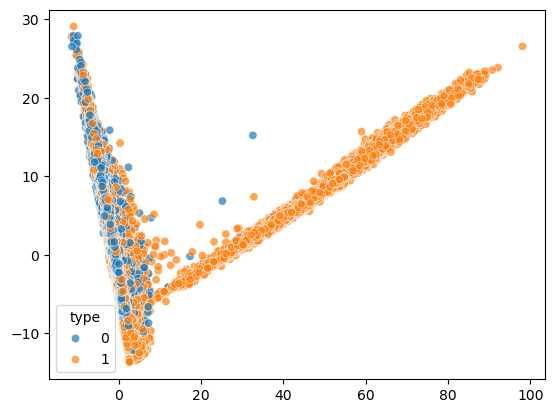

In [16]:
#PCA_df["type"] = fndf["type"]
sns.scatterplot(x = PCA_data[:, 0], y = PCA_data[:, 1], hue=fndf["type"], alpha=0.7)
#sns.scatterplot(data=PCA_df, x="PCA1", y="PCA2", hue="type", alpha=1)


<Axes: >

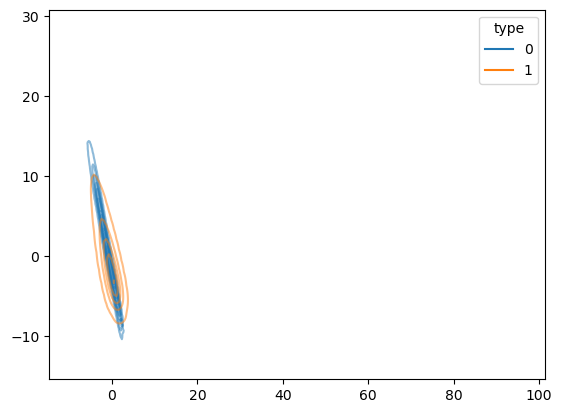

In [17]:
sns.kdeplot(x = PCA_data[:, 0], y = PCA_data[:, 1], hue=fndf["type"], fill=False, alpha=0.5)

In [ ]:
sns.scatterplot(x = PCA_data[:, 0], y = PCA_data[:, 1], hue=fndf["type"])

ValueError: Per-column arrays must each be 1-dimensional

<Axes: xlabel='PCA1', ylabel='PCA2'>

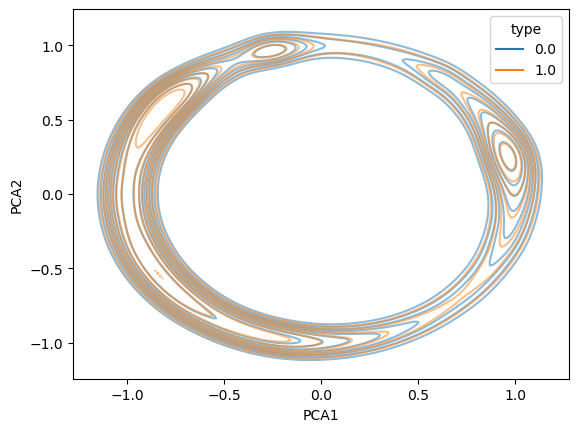

In [ ]:
sns.kdeplot(data=PCA_df, x="PCA1", y="PCA2", hue="type", thresh=0.15,alpha=0.5)

# observationer
- det virker ikke til at de er seperatble kun udfra bag in a word med tf-idf
- der er nogle regions hvor vi kan, og andre hvor vi ikke umiddelbart kan
- måske er f.eks. embeddings bedre?

In [ ]:
# tjek som ovenfor men med alle labels?


    Unnamed: 0       id                 domain  type  \
0        732.0  7444726     nationalreview.com     1   
1       1348.0  6213642      beforeitsnews.com     0   
2       7119.0  3867639       dailycurrant.com     0   
3       1518.0  9560791            nytimes.com     1   
4       9345.0  2059625    infiniteunknown.net     0   
..         ...      ...                    ...   ...   
95      4405.0  9523600            nytimes.com     1   
96      8642.0  3780677      beforeitsnews.com     0   
97       102.0      122  blackagendareport.com     0   
98      7550.0  6508433        www.newsmax.com     0   
99      3648.0  1357230       www.ammoland.com     0   

                                                  url  \
0   http://www.nationalreview.com/node/152734/%E2%...   
1   http://beforeitsnews.com/economy/2012/06/the-c...   
2   http://dailycurrant.com/2016/01/18/man-awoken-...   
3   https://query.nytimes.com/gst/fullpage.html?re...   
4   http://www.infiniteunknown.net/2011/09

Amount of words only present in one set than another: 272
[('said', np.float64(0.005989224878196336)), ('mr', np.float64(0.005948864596458583)), ('new', np.float64(0.0032736189032688033)), ('york', np.float64(0.003178806966138607)), ('main', np.float64(0.0027339084417915206)), ('pleas', np.float64(0.002594530014039337)), ('num', np.float64(0.002545392679506993)), ('stori', np.float64(0.002309711351794673)), ('continu', np.float64(0.0022946960553700494)), ('read', np.float64(0.0019017039205412203)), ('sign', np.float64(0.0017832534108624964)), ('advertis', np.float64(0.0016084235979338772)), ('republican', np.float64(0.0014991912922879464)), ('$', np.float64(0.001366216283543495)), ('democrat', np.float64(0.0012577113177079289)), ('offer', np.float64(0.001134012665539164)), ('servic', np.float64(0.0010641342366766002)), ('tri', np.float64(0.0010386466674621067)), ('later', np.float64(0.0010175592504107734)), ('percent', np.float64(0.0010033423376317222)), ('receiv', np.float64(0.0010026

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10857f350>>
Traceback (most recent call last):
  File "/Users/suneg/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


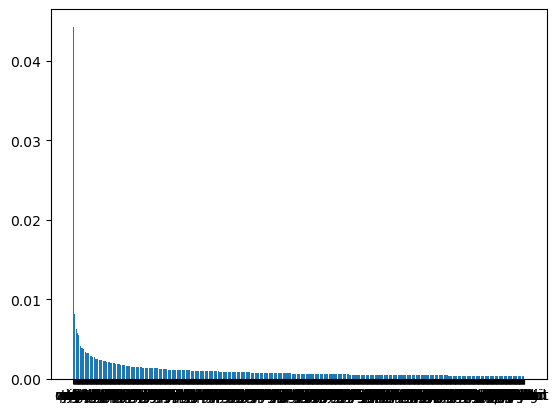

In [ ]:

real_set = set(real_pd.index)
fake_set = set(fake_pd.index)
unique_words = real_set.union(fake_set) - real_set.intersection(fake_set)
print(f"Amount of words only present in one set than another: {len(unique_words)}")

large_diff = [(word, real_pd.get(word, 0) - fake_pd.get(word, 0)) for word in fake_pd.index if abs(real_pd.get(word, 0) - fake_pd.get(word, 0)) > 0.00001]

large_diff.sort(key=lambda x: abs(x[1]), reverse=True)
print(large_diff)

print("Unique tokens:")
for token in ["url", "email", "num", "date"]:
    print(f"TOKEN: {token} - Real: {real_pd[token]}, Fake: {fake_pd[token]}")

plt.bar(real_pd.keys(), real_pd.values)
plt.show()

## Task 4

In [7]:
# Splitting into test, train and validation
X_train_full, X_valtest_full, y_train, y_valtest = train_test_split(fndf, fndf['type'], test_size=0.2, random_state=42) # Replace with fakenews dataset for real linreg.
X_test_full, X_val_full, y_test, y_val = train_test_split(X_valtest_full, y_valtest, test_size=0.5, random_state=42)
# x_train = testing_ x, y_train = training_y
# (x_test
X_train = X_train_full['content']
X_test = X_test_full['content']
print("train size:", y_train.shape)
print("val size:", y_val.shape)
print("test size:", y_test.shape)


train size: (578985,)
val size: (72374,)
test size: (72373,)


# Part 2

## Task 0, splitting labels into reliable and unreliable.

In [ ]:

unique_values = fndf['type'].unique()
print(unique_values)
#hard to know how to classify nan and unknown, so removed for now
# we also remove the a weird type 
fndf = fndf.dropna(subset=['type'])
fndf = fndf.loc[fndf['type']!='unknown']
# Need to reset index

newunique_values = fndf['type'].unique()
print(newunique_values)


# groups (reliable) as truenews 1 and (all others) in fakenews 0
    #note this is naive and should be reconsidered later

# reliable, clickbait and political are all, by their contents, factually correct (albeit possibly politcally motivated)
# we deem those to be "real" news
fndf['type'] = fndf['type'].replace(r'^(reliable|clickbait|political)$', '0', regex=True) 
fndf['type'] = fndf['type'].replace(r'^(?!0$).+', '1', regex=True)   # Replace everything except '1' with '0'
#fndf['type'] = fndf['type'].fillna('0')

newunique_values = fndf['type'].unique()
print(newunique_values)
fndf.shape[0]

['political' 'fake' 'satire' 'reliable' 'conspiracy' 'bias' 'clickbait'
 'hate' 'junksci']
['political' 'fake' 'satire' 'reliable' 'conspiracy' 'bias' 'clickbait'
 'hate' 'junksci']
['1' '0']


671128

In [ ]:
should_be_unrib = [fndf["type"] == 1]
print(should_be_unrib)

## Task 1 - Simple linear regression model.

Get the top 10000 words, and how often they occur in each article

In [ ]:
#Standarize fndf?

# get top 10000 words for vocab in training data to avoid leaking data from test set
print("Finding vocabulary:")
vocab = X_train.explode().value_counts()[:10000].keys()
#training_split_freq = FreqDist(X_train.explode())
#vocab = [x for (x, y) in training_split_freq.most_common(10000)]
#print(pd.Series(nsdf["content"][0]).value_counts())
#print(pd.Series(fndf["content"][0]).value_counts()[top.keys()[0]])

def CountFreq(words, vocab):
    # words: Series[str]
    # vocab: list[str] of words to count
    words = pd.Series(words)
    new_row = pd.Series(np.zeros(len(vocab)))
    n = len(vocab)
    words_in_article = pd.Series(words).value_counts()
    return vocab.apply(lambda x: words_in_article.get(x, 0))

#rowsFreq = X_train.parallel_apply(lambda row: CountFreq(row, pd.Series(top.keys())))
# her bruger vi forskellige vocabularies - vi skal finde vocab for træning og apply den til test_rowsFreq
vectorizer = CountVectorizer(analyzer=lambda x: x, vocabulary=vocab)
print("vectorizing X_train")
rowsFreq = vectorizer.fit_transform(X_train)
print("vectorizing X_test")
test_rowsFreq = vectorizer.transform(X_test)
print(rowsFreq)


Finding vocabulary:


In [7]:
#store data

joblib.dump((rowsFreq, test_rowsFreq), dataPath + "rowsFreq.pkl")
joblib.dump((y_train, y_test, y_val), dataPath + "y.pkl")
#joblib.dump((x_undersampled, y_undersampled), dataPath + "undersampled.pkl")
#joblib.dump((X_train_full, X_test_full, X_val_full), dataPath + "X_full.pkl")

['../data/y.pkl']

Creating the linear regression

In [ ]:
from imblearn.over_sampling import SMOTE

#scaler = StandardScaler(with_mean=False)
scaler = Normalizer()
undersampler = RandomUnderSampler(random_state=42)

X_train_scale = scaler.fit_transform(rowsFreq)
X_test_scale = scaler.transform(test_rowsFreq)
x_undersampled, y_undersampled = undersampler.fit_resample(X_train_scale, y_train)
x_undersampled = scaler.transform(x_undersampled)
print("Starting model training:")
linReg = LogisticRegression(max_iter=1000, penalty="l1", solver='liblinear', random_state=42)#, class_weight="balanced")
#linReg_weighed = LogisticRegression(max_iter=1000, penalty="l1", C=0.7, solver='saga', verbose=1, random_state=42, class_weight="balanced", n_jobs=8)
linReg_weighed = LogisticRegression(max_iter=1000, penalty="l1", solver='liblinear', class_weight="balanced", random_state=42)
linReg_undersampled = LogisticRegression(max_iter=1000, penalty="l1", solver='liblinear', random_state=42)
print("fitting standard model")
linReg.fit(X_train_scale, y_train)
print("fitting weighted model")
linReg_weighed.fit(X_train_scale, y_train)
print("fitting undersampled model")
#linReg_undersampled.fit(x_undersampled, y_undersampled)

y_pred = linReg.predict(X_test_scale)
y_pred_weighted = linReg_weighed.predict(X_test_scale)
y_pred_undersampled = linReg_undersampled.predict(X_test_scale)
f1 = f1_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred_weighted)
f1_undersampled = f1_score(y_test, y_pred_undersampled)
# Print results
print("Standard : Weighted : Undersampled")
print(f"F1 Score: {f1:.4f} : {f1_weighted:.4f} : {f1_undersampled:.4f}")
print(f"Hyperparameters: max_iter=1000, solver='liblinear', binary bag-of-words")


Starting model training:
fitting standard model


: 

: 

In [ ]:
""""
Starting model training:
fitting standard model
fitting weighted model
fitting undersampled model
Standard : Weighted : Undersampled
F1 Score: 0.8229 : 0.8290 : 0.8281
Hyperparameters: max_iter=1000, solver='liblinear', binary bag-of-words"
"""

In [ ]:
# Save model
# f1 : 82.9, f1-unweighted : 82.2 med swapped
joblib.dump((linReg, linReg_weighed), dataPath + "linReg.pkl")

In [ ]:
# Reload data 
(linReg, linReg_weighed, linReg_undersampled) = joblib.load(dataPath + "linReg.pkl")
(rowsFreq, test_rowsFreq) = joblib.load(dataPath + "rowsFreq.pkl")
(y_train, y_test, y_val) = joblib.load(dataPath + "y.pkl")
#(x_undersampled, y_undersampled) = joblib.load(dataPath + "undersampled.pkl")

scaler = Normalizer()
X_train_scale = scaler.fit_transform(rowsFreq)
X_test_scale = scaler.transform(test_rowsFreq)

y_pred = linReg.predict(X_test_scale)
y_train_pred = linReg.predict(X_train_scale)

Accuracy (test): 0.8477


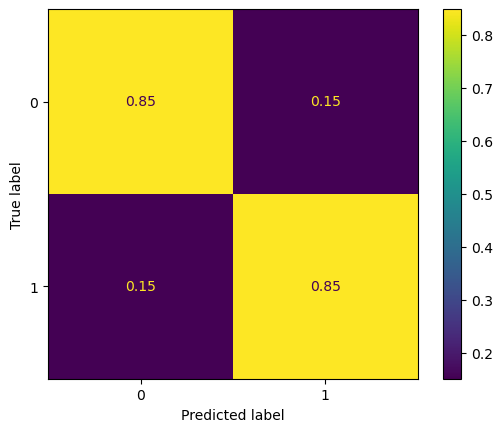

In [28]:
#Visualize
#print(f"F1 Score: Train: {f1_score(y_train, y_train_pred):.4f}, Test: {f1_score(y_test, y_pred):.4f}")
print(f"Accuracy (test): {accuracy_score(y_test, y_pred_weighted):.4f}")

cm = confusion_matrix(y_test, y_pred_weighted, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=linReg.classes_)
disp.plot()
plt.show()

### Task 3

In [ ]:
bbc_raw = pd.from_csv(dataPath + "bbc_articles.csv")

bbc_processed = processData(bbc_raw, 'text')
bbc_processed['type'] = 1

bbc_processed.to_json(dataPath + "bbc_processed.json", orient='records', lines=True)


In [ ]:
if bbc_proccessed is None:
    json_reader = pd.read_json(dataPath + "bbc_processed.json", orient='records', lines=True, chunksize=1500)
    bbc_processed = pd.concat(json_reader, ignore_index=True)

bbcdf = bbc_processed

BBC_train = pd.concat([X_train, bbcdf['text']]).reset_index(drop=True)
BBC_train = scaler.fit_transform(BBC_train)
BBC_y = pd.concat([y_train, bbcdf["type"]])
bbcReg = LogisticRegression(max_iter=1000, penalty="l1", solver='liblinear', random_state=42)
bbcReg.fit(BBC_train, BBC_y)
BBC_pred = bbcReg.predict(X_test)
print(f"F1: {f1_score(y_test, BBC_pred)}")

# advanced model

In [ ]:
print(X_train.to_frame().reset_index(drop=False))

         index                                            content
0       433076  [articl, friday, challeng, make, market, beave...
1       285997  [justic, eric, garner, street, protest, prosec...
2       182142  [van, gundi, state, long, ago, two, three, poi...
3       319275  [sedco, jone, recogn, manufactur, day, reader,...
4       691056  [san, francisco, gov, arnold, schwarzenegg, po...
...        ...                                                ...
650324  259178  [purdu, univers, purdu, pete, circa, num, poss...
650325  365838  [new, rnc, tv, ad, ok, reader, think, stori, f...
650326  131932  [recent, turkish, polit, circl, talk, white, t...
650327  671155  [mani, news, outlet, report, earlier, today, h...
650328  121958  [sport, time, column, last, sunday, new, men, ...

[650329 rows x 2 columns]


In [ ]:
# create document embeddings
#tagged_docs = [gensim.models.doc2vec.TaggedDocument(doc, [i]) for i, doc in enumerate(X_train)]
print("tagging documents")
# brug reset index måske?
#tagged_docs = list(map(gensim.models.doc2vec.TaggedDocument, X_train, X_train.index))
tagged_docs = [TaggedDocument(words=doc, tags=[i]) for doc, i in zip(X_train.values, range(X_train.shape[0]))]


tagging documents


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x103356de0>>
Traceback (most recent call last):
  File "/Users/suneg/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x103356de0>>
Traceback (most recent call last):
  File "/Users/suneg/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
KeyboardInterrupt: 


In [ ]:
vector_size = 100
embed_model = gensim.models.doc2vec.Doc2Vec(tagged_docs, vector_size=vector_size, min_count=2, workers=4)

NameError: name 'gensim' is not defined

In [ ]:
embed_model.save(dataPath + "doc2vec.model")

2025-03-19 23:39:57,536 : INFO : Doc2Vec lifecycle event {'fname_or_handle': '../data/doc2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-03-19T23:39:57.536338', 'gensim': '4.3.3', 'python': '3.12.8 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 10:37:40) [Clang 14.0.6 ]', 'platform': 'macOS-15.3.1-arm64-arm-64bit', 'event': 'saving'}
2025-03-19 23:39:57,560 : INFO : storing np array 'vectors' to ../data/doc2vec.model.dv.vectors.npy
2025-03-19 23:40:00,940 : INFO : storing np array 'vectors' to ../data/doc2vec.model.wv.vectors.npy
2025-03-19 23:40:02,301 : INFO : storing np array 'syn1neg' to ../data/doc2vec.model.syn1neg.npy
2025-03-19 23:40:02,711 : INFO : not storing attribute cum_table
2025-03-19 23:40:09,518 : INFO : saved ../data/doc2vec.model


In [10]:
embed_model = gensim.models.doc2vec.Doc2Vec.load(dataPath + "doc2vec.model")

2025-03-25 19:37:35,907 : INFO : loading Doc2Vec object from ../data/doc2vec.model
2025-03-25 19:37:36,107 : INFO : loading dv recursively from ../data/doc2vec.model.dv.* with mmap=None
2025-03-25 19:37:36,108 : INFO : loading vectors from ../data/doc2vec.model.dv.vectors.npy with mmap=None
2025-03-25 19:37:36,232 : INFO : loading wv recursively from ../data/doc2vec.model.wv.* with mmap=None
2025-03-25 19:37:36,233 : INFO : loading vectors from ../data/doc2vec.model.wv.vectors.npy with mmap=None
2025-03-25 19:37:36,345 : INFO : loading syn1neg from ../data/doc2vec.model.syn1neg.npy with mmap=None
2025-03-25 19:37:36,472 : INFO : setting ignored attribute cum_table to None
2025-03-25 19:37:38,417 : INFO : Doc2Vec lifecycle event {'fname': '../data/doc2vec.model', 'datetime': '2025-03-25T19:37:38.417088', 'gensim': '4.3.3', 'python': '3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]', 'platform': 'macOS-15.3.1-arm64-arm-64bit', 'event': 'loaded'}


In [11]:
X_test_embed = pd.DataFrame([embed_model.infer_vector(doc) for doc in X_test])


In [15]:
joblib.dump(X_test_embed, dataPath + "X_test_embed.pkl")
joblib.dump(X_train_embedded, dataPath + "X_train_embed.pkl")

['../data/X_train_embed.pkl']

In [ ]:
X_test_embed = joblib.load(dataPath + "X_test_embed.pkl")
X_train_embedded = joblib.load(dataPath + "X_train_embedded.pkl")
(y_train, y_test, y_val) = joblib.load(dataPath + "y.pkl")

In [13]:
from gensim.similarities import Similarity
print("X_train embedded:")
X_train_embedded = pd.DataFrame([embed_model.infer_vector(doc) for doc in X_train])

X_train embedded:


<Axes: xlabel='PCA1', ylabel='PCA2'>

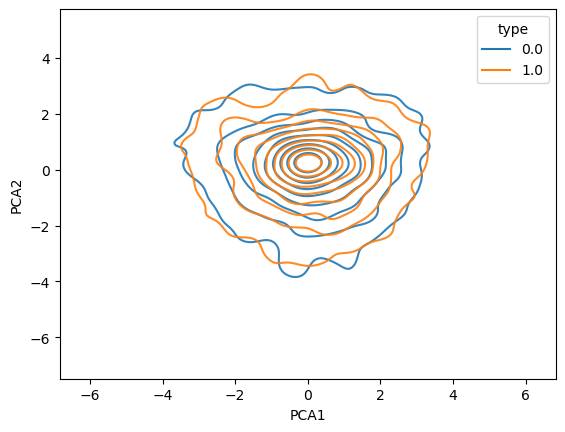

In [ ]:
import seaborn as sns
from sklearn.decomposition import PCA
PCA_embedded = PCA(n_components=2)
trained_embedded = pd.DataFrame(embed_model.dv.vectors)
PCA_embedded.fit(trained_embedded)
test_embedded = PCA_embedded.transform(X_test_embed.to_list())
test_embedded = pd.DataFrame(test_embedded, columns=["PCA1", "PCA2"])
test_embedded["type"] = y_test

sns.kdeplot(data=test_embedded, x="PCA1", y="PCA2", hue="type", alpha=0.9)



In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
"""
svc = LinearSVC(random_state=42, verbose=1, class_weight="balanced")
svc.fit(X_train_embedded, y_train)
y_pred_svc = svc.predict(X_test_embed.to_list())
print(f"F1 Score: {f1_score(y_test, y_pred_svc):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc):.4f}")
"""
scaler = Normalizer()
tf_idf_model = TfidfVectorizer(max_features=10000, analyzer=lambda x: x)
tfidf_train = tf_idf_model.fit_transform(X_train)
tfidf_train = scaler.fit_transform(tfidf_train)
# alpha = 0.001 = 0.88 f1
mlp = MLPClassifier(max_iter = 2000, random_state=42, verbose=1, early_stopping=True, alpha=0.0015)
mlp.fit(tfidf_train, y_train)
tfidf_test = tf_idf_model.transform(X_test)
tfidf_test = scaler.transform(tfidf_test)
y_pred_mlp = mlp.predict(tfidf_test)
print(f"F1 Score: {f1_score(y_test, y_pred_mlp):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")

#building neural network
# 0.777 both acc and f1
"""
mlp = MLPClassifier(max_iter = 2000, random_state=42, verbose=1)
mlp.fit(X_train_embedded, y_train)
y_pred_mlp = mlp.predict(X_test_embed.to_list())
print(f"F1 Score: {f1_score(y_test, y_pred_mlp):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")
# f1 =. .8048

"""




: 

: 

In [17]:
scaler = Normalizer()
tf_idf_model = TfidfVectorizer(max_features=10000, analyzer=lambda x: x)
tfidf_train = tf_idf_model.fit_transform(X_train)
tfidf_train = scaler.fit_transform(tfidf_train)

tfidf_test = tf_idf_model.transform(X_test)
tfidf_test = scaler.transform(tfidf_test)

In [18]:

joblib.dump((tfidf_train, tfidf_test), dataPath + "tfidf.pkl")

['../data/tfidf.pkl']

In [ ]:
joblib.dump(mlp, dataPath + "mlp_1.pkl")
joblib.dump((tfidf_train, tfidf_test), dataPath + "tfidf.pkl")
print("for training:")
print(f"F1 Score: {f1_score(y_train, mlp.predict(tfidf_train)):.4f}")

In [ ]:
mlp = joblib.load(dataPath + "mlp_1.pkl")
(tfidf_train, tfidf_test) = joblib.load(dataPath + "tfidf.pkl")

In [20]:
import scipy.sparse as sp

# scale doc embeddings
scaler = Normalizer()
X_train_embedded_scaled = scaler.fit_transform(X_train_embedded)
X_test_embed_scaled = scaler.transform(X_test_embed)

# double feature set
print(tfidf_train.shape)
print(X_train_embedded.shape)
print(X_test_embed.shape)
print(type(tfidf_train))
print(type(X_train_embedded))
print(type(X_test_embed))
dense_train_embed = sp.csr_matrix(X_train_embedded_scaled)
dense_test_embed = sp.csr_matrix(X_test_embed_scaled)
total_train = sp.hstack([tfidf_train, dense_train_embed])
total_test = sp.hstack([tfidf_test, dense_test_embed])
print(total_train.shape)


(536902, 10000)
(536902, 100)
(67113, 100)
<class 'scipy.sparse._csr.csr_matrix'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(536902, 10100)


In [ ]:
# test logistic on super-
logistic_total = LogisticRegression(max_iter=1000, penalty="l1", solver='liblinear', random_state=42)
logistic_total.fit(total_train, y_train)
y_pred_total = logistic_total.predict(total_test)
print(f"F1 Score: {f1_score(y_test, y_pred_total):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_total):.4f}")

F1 Score: 0.8580
Accuracy: 0.8513


In [ ]:
#neural
mlp_total = MLPClassifier(max_iter = 2000, random_state=42, verbose=1, alpha=0.01, early_stopping=True)
mlp = MLPClassifier(max_iter = 2000, random_state=42, verbose=1, early_stopping=True, alpha=0.0015)
mlp_total.fit(total_train, y_train)
y_pred_mlp_total = mlp_total.predict(total_test)
print(f"F1 Score: {f1_score(y_test, y_pred_mlp_total):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp_total):.4f}")

Iteration 1, loss = 0.36725676
Validation score: 0.850775
Iteration 2, loss = 0.32826589
Validation score: 0.864523
Iteration 3, loss = 0.30116506
Validation score: 0.873521
Iteration 4, loss = 0.28090253
Validation score: 0.877563
Iteration 5, loss = 0.26518862
Validation score: 0.878823
Iteration 6, loss = 0.25187377
Validation score: 0.880188
Iteration 7, loss = 0.23990666
Validation score: 0.879946
Iteration 8, loss = 0.22888354
Validation score: 0.878875
Iteration 9, loss = 0.21917251
Validation score: 0.878737
Iteration 10, loss = 0.21078511
Validation score: 0.879065
Iteration 11, loss = 0.20313539
Validation score: 0.877459
Iteration 12, loss = 0.19692430
Validation score: 0.877977
Iteration 13, loss = 0.19163277
Validation score: 0.877390
Iteration 14, loss = 0.18710004
Validation score: 0.878046
Iteration 15, loss = 0.18355007
Validation score: 0.876475
Iteration 16, loss = 0.18091820
Validation score: 0.874316
Iteration 17, loss = 0.17809060
Validation score: 0.874454
Valida

In [ ]:
logistic_total = LogisticRegression(max_iter=1000, penalty="l1", solver='liblinear', random_state=42)
logistic_total.fit(total_train, y_train)
y_pred_total = logistic_total.predict(total_test)
print(f"F1 Score: {f1_score(y_test, y_pred_total):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_total):.4f}")

F1 Score: 0.8586
Accuracy: 0.8519


In [21]:
# creating voting classifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

mlp_total = MLPClassifier(max_iter = 2000, random_state=42, verbose=1, alpha=0.01, early_stopping=True)

neural_only_embed = Pipeline([
    ('only_embed', ColumnTransformer([('embeds', 'passthrough', slice(10000, None))])),
    ('scaler', Normalizer()),
    ('mlp', MLPClassifier(max_iter = 2000, random_state=42, verbose=1))
])

neural_only_tfidf = Pipeline([
    ('only_tfidf', ColumnTransformer([('tfidf', 'passthrough', slice(0, 10000))])),
    ('mlp', MLPClassifier(max_iter = 2000, random_state=42, verbose=1, early_stopping=True, alpha=0.005))
])


voting = VotingClassifier(estimators=[('only_tfidf', neural_only_tfidf), ('mlp', mlp_total), ('only_embed', neural_only_embed)], voting='soft', weights=[0.75, 1, 0.75])
voting.fit(total_train, y_train)
y_pred = voting.predict(total_test)
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Iteration 1, loss = 0.37415365
Validation score: 0.839712
Iteration 2, loss = 0.34944676
Validation score: 0.847554
Iteration 3, loss = 0.32764064
Validation score: 0.859828
Iteration 4, loss = 0.30712170
Validation score: 0.865527
Iteration 5, loss = 0.29048707
Validation score: 0.868376
Iteration 6, loss = 0.27530233
Validation score: 0.870276
Iteration 7, loss = 0.26055761
Validation score: 0.870556
Iteration 8, loss = 0.24612417
Validation score: 0.870574
Iteration 9, loss = 0.23248738
Validation score: 0.870611
Iteration 10, loss = 0.21989073
Validation score: 0.869811
Iteration 11, loss = 0.20918771
Validation score: 0.868246
Iteration 12, loss = 0.20003804
Validation score: 0.867576
Iteration 13, loss = 0.19316738
Validation score: 0.867240
Iteration 14, loss = 0.18763251
Validation score: 0.867371
Iteration 15, loss = 0.18318761
Validation score: 0.867054
Iteration 16, loss = 0.17974468
Validation score: 0.864856
Iteration 17, loss = 0.17716904
Validation score: 0.865341
Iterat

In [22]:
# f1 = 0.887
# swapped labels: 0.8616, accuracy = 0.8792
joblib.dump(voting, dataPath + "voting_weighted.pkl")

['../data/voting_weighted.pkl']

Accuracy (test): 0.8792


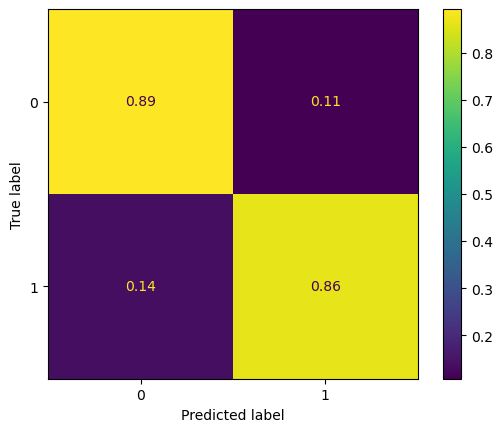

F1 Score: 0.8547
Accuracy: 0.8727
F1 Score: 0.8567
Accuracy: 0.8746
F1 Score: 0.7742
Accuracy: 0.8055


In [35]:
y_pred_total = voting.predict(total_test)
print(f"Accuracy (test): {accuracy_score(y_test, y_pred_total):.4f}")

cm = confusion_matrix(y_test, y_pred_total, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting.classes_)
disp.plot()
plt.show()

for model in voting.estimators_:
    print(f"F1 Score: {f1_score(y_test, model.predict(total_test)):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, model.predict(total_test)):.4f}")

In [ ]:
#f1 = 0.887
joblib.dump(voting, dataPath + "voting.pkl")

['../data/voting.pkl']

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

mlp_reduced = MLPClassifier(max_iter =200, random_state=42, verbose=1, alpha=0.0005)# increase regularization
print("starting pca")
pca_tfidf = PCA(n_components=400)
tfidf_train_feareduced = pca_tfidf.fit_transform(tfidf_train)
tfidf_test_feareduced = pca_tfidf.transform(tfidf_test)

In [ ]:
print("fitting model:")
mlp_reduced.fit(tfidf_train_feareduced, y_train)
y_pred_mlp_reduced = mlp_reduced.predict(tfidf_test_feareduced)
# f1 = 0.853
print(f"F1 Score: {f1_score(y_test, y_pred_mlp_reduced):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp_reduced):.4f}")

In [ ]:
print("for training:")
# f1 = 0.91 
print("F1 Score: ", f1_score(y_train, mlp_reduced.predict(tfidf_train_feareduced)))

#### Trying HistGradientBoostingClassifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, analyzer=lambda x: x)
X_training = vectorizer.fit_transform(X_train)
X_testing = vectorizer.transform(X_test)

In [ ]:
# k nearest neighbour
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
scaler = Normalizer()
X_test_embed = np.array([np.array(x) for x in X_test_embed])
print(X_test_embed)
print(X_train_embedded.shape)

X_train_embed_scale = scaler.fit_transform(X_train_embedded)
X_test_embed_scale = scaler.fit_transform(X_test_embed)

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
print("fitting model")
knn.fit(X_train_embed_scale, y_train)
y_pred_knn = knn.predict(X_test_embed_scale)
print(f"F1 Score: {f1_score(y_test, y_pred_knn):.4f}")

In [ ]:
import fasttext
import fasttext.util

fasttext.util.download_model('en', if_exists='ignore')  
ft = fasttext.load_model('cc.en.300.bin')
fasttext.util.reduce_model(ft, 100)

In [ ]:
### Gradient Descent random forest
from sklearn.decomposition import PCA

pca = PCA(n_components=400)

X_training_pca = pca.fit_transform(X_training)
X_testing_pca = pca.transform(X_testing)


from sklearn.ensemble import HistGradientBoostingClassifier

HGBC = HistGradientBoostingClassifier(max_iter=500, random_state=42, verbose=1)

HGBC.fit(X_training_pca, y_train)
y_pred = HGBC.predict(X_testing_pca)
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

In [ ]:
# training word2vec
import gensim.models
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

model_stem = gensim.models.Word2Vec(X_train, vector_size=100, min_count=2, workers=6)

model_stem.save(dataPath + "word2vec.model")

In [ ]:
vocab = [word for (index, word) in enumerate(model_stem.wv.index_to_key) if index < 10000]
tfidf_scaler = TfidfVectorizer(vocabulary=vocab, analyzer=lambda x: x)
tfidf_train = tfidf_scaler.fit_transform(X_train)
tfidf_test = tfidf_scaler.transform(X_test)

scaler = Normalizer()
embedding_norm = scaler.fit_transform(model_stem.wv.vectors[:10000])
print(tfidf_train.shape, model_stem.wv.vectors[:10000].shape)
print("finding training")
tfidf_embeddings = tfidf_train.dot(embedding_norm)
print("finding testing")
tfidf_test_embeddings = tfidf_test.dot(embedding_norm)
tfidf_embeddings = scaler.fit_transform(tfidf_embeddings)
tfidf_test_embeddings = scaler.transform(tfidf_test_embeddings)

In [ ]:
#training neural network on weighted embeddings
from sklearn.neural_network import MLPClassifier
mlp_tfidf = MLPClassifier(max_iter=2000, random_state=42, verbose=1, hidden_layer_sizes=(100, 100))
mlp_tfidf.fit(tfidf_embeddings, y_train)
y_pred_mlp_tfidf = mlp_tfidf.predict(tfidf_test_embeddings)
print(f"F1 Score: {f1_score(y_test, y_pred_mlp_tfidf):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp_tfidf):.4f}")

In [ ]:
# process without stemming
df_arr = []
chunk_len = 60000
pandarallel.initialize(progress_bar=False)
for section in pd.read_csv(dataPath + "995,000_rows.csv", chunksize=chunk_len):
    section.dropna(subset=['content'], inplace=True)
    section.drop(columns=['Unnamed: 0'], inplace=True)
    section.drop_duplicates(subset=['content'], inplace=True)
    section.reset_index(drop=True, inplace=True)
    section = section.loc[(section['type']!='unknown') & (section['type']!='unreliable') & (section['type'] != '2018-02-10 13:43:39.521661')]
    section_processed = processData(section, 'content', stemming=False)

    df_arr.append(section_processed)
    print("processed ", chunk_len*len(df_arr))

print("merging")
df = pd.concat(df_arr, ignore_index=True, copy=False)
df.drop_duplicates(subset=['content'], inplace=True)
df.to_json(dataPath + "news_processed_noStem.json", orient='records', lines=True)


In [ ]:
json_reader = pd.read_json(dataPath + "news_processed_nostem.json", orient='records', lines=True, chunksize=15000)
df_nostem = pd.concat(json_reader, ignore_index=True)
#df_nostem.drop_duplicates(subset=['content']).to_json(dataPath + "news_processed_nostem.json", orient='records', lines=True)

In [ ]:
df_nostem['type'] = df_nostem['type'].replace(r'^(reliable|clickbait|political)$', '1', regex=True) 
df_nostem['type'] = df_nostem['type'].replace(r'^(?!1$).+', '0', regex=True)   # Replace everything except '1' with '0'
#maybe fix this? what remains?
df_nostem['type'] = df_nostem['type'].fillna('0')

In [ ]:
X_nostem_train, X_nostem_valtest, y_nostem_train, y_nostem_valtest = train_test_split(df_nostem["content"], df_nostem['type'], test_size=0.2, random_state=42) # Replace with fakenews dataset for real linreg.
X_nostem_test, X_nostem_val, y_nostem_test, y_nostem_val = train_test_split(X_nostem_valtest, y_nostem_valtest, test_size=0.5, random_state=42)
# x_train = testing_ x, y_train = training_y
# (x_test
print("train size:", y_nostem_train.shape)
print("val size:", y_nostem_val.shape)
print("test size:", y_nostem_test.shape)

train size: (612836,)
val size: (76605,)
test size: (76604,)


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, analyzer=lambda x: x)
X_nostem_train_tfidf = tfidf_vectorizer.fit_transform(X_nostem_train)
X_nostem_test_tfidf = tfidf_vectorizer.transform(X_nostem_test)
vocab = tfidf_vectorizer.vocabulary_

In [ ]:
# allocate array order
word_order = np.empty(len(vocab), dtype=object)
for word, key in vocab.items():
    word_order[key] = word

['+' '10th' '11th' '12th' '13th' '14th' '15th' '16th' '17th' '18th'
 '1920s' '1930s' '1950s' '1960s' '1970s' '1980s' '1990s' '19th' '1st'
 '20th' '21st' '25th' '2nd' '3d' '3rd' '4th' '50th' '5th' '60s' '6th'
 '70s' '7th' '80s' '8th' '90s' '9th' '<' '=' '>' 'aaron' 'abandon'
 'abandoned' 'abbas' 'abbott' 'abc' 'abdul' 'abdullah' 'abe' 'abilities'
 'ability' 'able' 'aboard' 'abortion' 'abortions' 'abraham' 'abroad'
 'absence' 'absent' 'absolute' 'absolutely' 'absorb' 'absorbed' 'abstract'
 'absurd' 'abu' 'abundance' 'abundant' 'abuse' 'abused' 'abuses' 'abusive'
 'aca' 'academic' 'academics' 'academy' 'accelerate' 'accelerated'
 'accept' 'acceptable' 'acceptance' 'accepted' 'accepting' 'access'
 'accessible' 'accessories' 'accident' 'accidental' 'accidentally'
 'accidents' 'accommodate' 'accompanied' 'accompanying' 'accomplish'
 'accomplished' 'accomplishments' 'accord' 'accordance' 'according'
 'accordingly' 'account']


In [ ]:
embedding_matrix = np.array([ft.get_word_vector(word) for word in word_order])
print(embedding_matrix.shape)

(10000, 100)


In [ ]:
scaler = Normalizer()
X_nostem_train_tfidf = scaler.fit_transform(X_nostem_train_tfidf)
X_nostem_test_tfidf = scaler.transform(X_nostem_test_tfidf)

In [ ]:
tfidf_embedding_nostem_train = X_nostem_train_tfidf.dot(embedding_matrix)
tfidf_embedding_nostem_test = X_nostem_test_tfidf.dot(embedding_matrix)

scaler_two = Normalizer()
tfidf_embedding_nostem_train = scaler_two.fit_transform(tfidf_embedding_nostem_train)
tfidf_embedding_nostem_test = scaler_two.transform(tfidf_embedding_nostem_test)

In [ ]:
print(tfidf_embedding_nostem_train, y_nostem_train)

[[-0.08901996 -0.31043205 -0.00751298 ...  0.07764784  0.02849071
  -0.04451792]
 [-0.00942364 -0.41735513 -0.08350673 ...  0.04636339  0.02409255
  -0.01110579]
 [-0.09985403 -0.46483764 -0.0686444  ...  0.00677747  0.04605391
   0.00738094]
 ...
 [-0.42827532 -0.09776017 -0.00479608 ...  0.16286168 -0.00326615
   0.00083694]
 [-0.01463786 -0.3314303  -0.10773966 ...  0.02876785  0.00295276
   0.08959455]
 [-0.01025202 -0.21647019 -0.04012988 ...  0.10401359 -0.02724308
   0.01562457]] 398       political
528904    political
69632       junksci
61750      reliable
695692       satire
            ...    
259178     reliable
365838     reliable
131932         bias
671155    political
121958     reliable
Name: type, Length: 612836, dtype: object


In [ ]:
y_nostem_train = y_nostem_train.replace(r'^(reliable|clickbait|political)$', '1', regex=True) 
y_nostem_train = y_nostem_train.replace(r'^(?!1$).+', '0', regex=True)   # Replace everything except '1' with '0'
#maybe fix this? what remains?
y_nostem_train = y_nostem_train.fillna('0')

y_nostem_test = y_nostem_test.replace(r'^(reliable|clickbait|political)$', '1', regex=True) 
y_nostem_test = y_nostem_test.replace(r'^(?!1$).+', '0', regex=True)   # Replace everything except '1' with '0'
#maybe fix this? what remains?
y_nostem_test = y_nostem_test.fillna('0')

In [ ]:
from sklearn.svm import LinearSVC
linearSVM = LinearSVC(max_iter=2000, random_state=42, verbose=1, class_weight="balanced", penalty="l1")
linearSVM.fit(tfidf_embedding_nostem_train, y_nostem_train)
y_pred_nostem = linearSVM.predict(tfidf_embedding_nostem_test)

[LibLinear]................................................................................................................................................................*......................
optimization finished, #iter = 1823
Objective value = 465845.580733
#nonzeros/#features = 101/101


In [ ]:
from sklearn.neural_network import MLPClassifier
mlp_nostem = MLPClassifier(max_iter=2000, random_state=42, verbose=1, hidden_layer_sizes=(100, 20))
mlp_nostem.fit(tfidf_embedding_nostem_train, y_nostem_train)
y_pred_mlp_nostem = mlp_nostem.predict(tfidf_embedding_nostem_test)

Iteration 1, loss = 0.51065692


/Users/suneg/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
print("F1 Score: ", f1_score(y_nostem_test.astype(int), y_pred_nostem.astype(int)))
print("Accuracy: ", accuracy_score(y_nostem_test.astype(int), y_pred_nostem.astype(int)))

F1 Score:  0.7151730024292561
Accuracy:  0.7168424625345935


<Axes: xlabel='PCA1', ylabel='PCA2'>

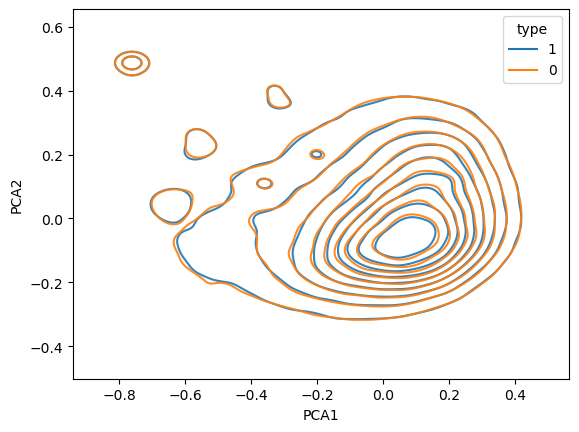

In [ ]:
import seaborn as sns
from sklearn.decomposition import PCA
PCA_embedded = PCA(n_components=2)
trained_embedded = pd.DataFrame(tfidf_embedding_nostem_train)
PCA_embedded.fit(trained_embedded)
test_embedded = PCA_embedded.transform(tfidf_embedding_nostem_train)
test_embedded = pd.DataFrame(test_embedded, columns=["PCA1", "PCA2"])
test_embedded["type"] = y_nostem_train

sns.kdeplot(data=test_embedded, x="PCA1", y="PCA2", hue="type", alpha=0.9)

In [ ]:
embedding_matrix = joblib.load(dataPath + "embedding_matrix.pkl")
vocab_nostem = joblib.load(dataPath + "vocab_nostem.pkl")

In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing import Tokenizer

tf_tokens = Tokenizer(num_words = len(tfidf_vectorizer.vocabulary_), oov_token="<OOV>")
tf_tokens.word_index = tfidf_vectorizer.vocabulary_

sequenc_test = tf_tokens.texts_to_sequences(["test", "this", "putin", "trump"])

2.17.0


ImportError: cannot import name 'clip_to_image_size' from 'keras.src.layers.preprocessing.image_preprocessing.bounding_boxes.converters' (/Users/suneg/miniconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/image_preprocessing/bounding_boxes/converters.py)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.python.keras.models import Sequential

MAX_SEQUENCE_LENGTH = 200

model = Sequential([
    Embedding(input_dim=10000, output_dim=100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

ImportError: cannot import name 'clip_to_image_size' from 'keras.src.layers.preprocessing.image_preprocessing.bounding_boxes.converters' (/Users/suneg/miniconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/image_preprocessing/bounding_boxes/converters.py)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, analyzer=lambda x: x)
X_nostem_train_tfidf = tfidf_vectorizer.fit_transform(X_nostem_train)
X_nostem_test_tfidf = tfidf_vectorizer.transform(X_nostem_test)
vocab = tfidf_vectorizer.vocabulary_

In [ ]:
# simple logistic with tf-idf


python(63005) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

BartModel(
  (shared): Embedding(50265, 768, padding_idx=1)
  (encoder): BartEncoder(
    (embed_tokens): Embedding(50265, 768, padding_idx=1)
    (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
    (layers): ModuleList(
      (0-5): 6 x BartEncoderLayer(
        (self_attn): BartSdpaAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layernorm_embedding)